<a href="https://colab.research.google.com/github/LironSimon/modular_dl_algos/blob/main/DCGan_and_WGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports & Downloads**
*Imports all needed packages,* and loads the Pen TreeBank dataset from a folder in the Drive.*

***An action is needed in the 2nd and 3rd cells!***



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tqdm.notebook as tq
from enum import Enum, auto
import pickle

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import save_image

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**2. Mount to Drive.** *Ensures we can save information to Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**3. Change to a relavent path** *to be able to save or load data properly.*

In [ ]:
##########################################
# ACTION NEEDED! Change to a relevant path
##########################################

path = '/content/gdrive/MyDrive/Deep Learning/EX3_302338470/Q4 - saved data'

**4. Define hyperparameters.** *Parameters are based on the numbers stated in Gulrajani et al. [2017].*

In [ ]:
epochs = 5000
batch_size = 64
kernel_size = 4 
stride = 2
padding = 1
learning_rate_DCGan = 2e-4
learning_rate_WGan = 1e-4 

Dim = 64   # model dimensionality
img_Dim = 32
latent_size = 128
Lambda = 10 # Gradient penalty lambda hyperparameter

**5. load FashionMnist data.** 

In [ ]:
# criterion to transform loaded PIL images to a normalized version
transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(2),transforms.Normalize([0.5], [0.5])])

# download datasets:
imported_trainset = datasets.FashionMNIST(root="./Dataset", download=True, train=True, transform=transform)
train_set = torch.utils.data.DataLoader(imported_trainset, batch_size=batch_size, shuffle=True)

imported_testset = datasets.FashionMNIST(root="./Dataset", download=True, train=False, transform=transform)
test_set = torch.utils.data.DataLoader(imported_testset, batch_size=batch_size, shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Dataset/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#**2. Setting the model** 

**1. Create the Generator & Discriminator.** *Discriminator is modular and changes accourding to Gans type.*

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    # create a model with the following layers:
    preprocess = nn.Sequential(nn.Linear(latent_size, 64*Dim), # linear (in_features, out_features, bias=True)
                               nn.BatchNorm1d(64*Dim),  # batch normalization over the 2D linear layer
                               nn.ReLU(True) )  #followed by ReLU
    self.preprocess = preprocess
    # create a model with the following layers:
    block1 = nn.Sequential(nn.ConvTranspose2d(4*Dim, 2*Dim, kernel_size, stride, padding), #transposed convolution operator over an input image (in_channels, out_channels, kernel_size, stride, padding)
                           nn.BatchNorm2d(2 * Dim),  # batch normalization over the 4D layer
                           nn.ReLU(True) ) 
    self.block1 = block1
    # create a model with the following layers:
    block2 = nn.Sequential(nn.ConvTranspose2d(2*Dim, Dim, kernel_size, stride, padding), # (in_channels, out_channels, kernel_size, stride, padding)
                           nn.BatchNorm2d(Dim),
                           nn.ReLU(True)) 
    self.block2 = block2
    # set the deconvolutional operator
    deconv_out = nn.ConvTranspose2d(Dim, 1, kernel_size, stride, padding)     
    self.deconv_out = deconv_out

    self.tanh = nn.Tanh()
    

  def forward(self, input):
    '''Applies on input the pre-processing network, reshapes it,
       and leads it as input to block1, followed by block2.
       Finishes by preforming a transposed convolution and tanh activation. '''
    output = self.preprocess(input)
    output = output.view(-1, 4*Dim, 4, 4)
    # apply block1, block2, deconvolution and tanh:
    output = self.block1(output)
    output = self.block2(output)
    output = self.deconv_out(output)
    output = self.tanh(output)
    return output


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, GanType):
    super().__init__()
    # define main network accourding to the needed Gan type 
    if GanType == GanType.DCGan:
      main = nn.Sequential(nn.Conv2d(1, Dim, kernel_size, stride, padding), # applies a 2D convolution over input (in_chanels, out_chanels, kernel_size, stride, padding)
                           nn.LeakyReLU(),
                           nn.Conv2d(Dim, 2*Dim, kernel_size, stride, padding),
                           nn.BatchNorm2d(2*Dim),
                           nn.LeakyReLU(),
                           nn.Conv2d(2*Dim, 4*Dim, kernel_size, stride, padding),
                           nn.BatchNorm2d(4*Dim),
                           nn.LeakyReLU() )
    else:
      main = nn.Sequential(nn.Conv2d(1, Dim, kernel_size, stride, padding),
                           nn.LeakyReLU(),
                           nn.Conv2d(Dim, 2 * Dim, kernel_size, stride, padding),
                           nn.LeakyReLU(),
                           nn.Conv2d(2 * Dim, 4 * Dim, kernel_size, stride, padding),
                           nn.LeakyReLU() )
    self.main = main
    # define operation to apply linear transfomation on input
    self.linear = nn.Linear(64*Dim, 1) #(in_features, out_features, bias=True)


  def forward(self, input):
    '''Applies on input the main network, reshapes it, and preforms a linear operation. '''
    output = self.main(input)
    output = output.view(-1, 64*Dim)
    output = self.linear(output)
    return output


In [ ]:
class GanType(Enum):
  '''Automatically assign integer values to the defined class attributes.'''
  DCGan = auto()
  WGan = auto()

**2. Create helpful functions** *for training the networks*

In [ ]:
def freeze_weights(net, freeze_bool):
  '''Freezes weights of the model so they don't get updated'''
  for param in net.parameters(): 
    param.requires_grad = not freeze_bool  

In [ ]:
def calc_gradient_penalty(Discriminator, real_data, fake_data):
    # create a tensor filled with random numbers from a uniform distribution of [0, 1)
    noise = torch.rand(batch_size, 1)
    noise = noise.expand(real_data.size()).to(device)
    # create a function to distort the noise
    interpolates = (( noise*real_data ) + ( (1 - noise)*fake_data )).to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    # feed noise to discriminator
    disc_interpolates = Discriminator(interpolates.view(batch_size, 1, img_Dim, img_Dim))
    # compute the sum of gradients of outputs with respect to the inputs
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              retain_graph=True, create_graph=True)[0]
  
    return (gradients.norm(2, dim=1) - 1) ** 2   # computed penalty


**3. setting the training loop.**


In [ ]:
def train(GanType,dicriminator_iterations, G_optimizer, D_optimizer, epochs=epochs, train_set=train_set,learning_rate_DCGan=learning_rate_DCGan): 
  pbar = tq.tqdm(range(epochs))
  for epoch in pbar:
    pbar.set_description(f'{GanType.name} Training... epoch{epoch}/{epochs}')

    freeze_weights(discriminator, False)
    freeze_weights(generator, True)

    for iter_d in range(dicriminator_iterations):
      # iterate over trainset to save data and set to tensor of cuda type
      data, _ = next(iter(train_set))
      real_data = torch.Tensor(data).to(device)
      real_data_V = autograd.Variable(real_data)
      
      discriminator.zero_grad()

      # feed the Discriminator with real data
      D_real = discriminator(real_data_V)
      
      # create noise tensor from a normal distribution with mean 0 and variance 1
      noise = torch.randn(batch_size, latent_size).to(device)
      noise_V = autograd.Variable(noise)

      # generate fake data from noise
      fake = autograd.Variable(generator(noise_V).data)

      # feed the Discriminator with fake data
      D_fake = discriminator(fake)    

      # calculate Loss considering the type of Gan:
      if GanType == GanType.DCGan:
        bceLoss_Real = bceLoss(sigmoid(D_real), torch.ones_like(D_real))
        bceLoss_Fake = bceLoss(sigmoid(D_fake), torch.zeros_like(D_real))
        D_loss = (bceLoss_Real+bceLoss_Fake)*0.5
      else: #this is a WGan type
        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(discriminator, real_data_V.view(batch_size, -1), fake.view(batch_size, -1))
        D_BatchLoss = D_fake - D_real + Lambda * gradient_penalty
        D_loss = D_BatchLoss.mean()   

      D_loss.backward()
      D_optimizer.step()
      loss_df.loc[epoch, 'Discriminator'] = D_loss.cpu().detach().numpy()

    ## Update Generator:
    freeze_weights(discriminator, True)
    freeze_weights(generator, False)

    generator.zero_grad()
    
    # create noise tensor from a normal distribution with mean 0 and variance 1
    noise = torch.randn(batch_size, latent_size).to(device)
    noise_V = autograd.Variable(noise)
    
    # generate fake data and feed it to the Discriminator
    fake = generator(noise_V)
    D_fake = discriminator(fake)

    # calculate Loss considering the type of Gan:
    if GanType == GanType.DCGan: G_loss = bceLoss(sigmoid(D_fake), torch.ones_like(D_fake))   
    else: G_loss = -D_fake.mean()   #this is a WGan type
       
    loss_df.loc[epoch, 'Generator'] = G_loss.cpu().detach().numpy()

    G_loss.backward()
    G_optimizer.step()
    
    if epoch % 500 == 0:
      print(f"epoch {epoch}: Generator Loss: {loss_df.loc[epoch, 'Generator']:.2f}, Discriminator Loss: {loss_df.loc[epoch, 'Discriminator']:.2f}")
      print('-'*100)

            
  return loss_df, generator.state_dict(), discriminator.state_dict()


# **3. Training the two Gans**

**1. Create a list to store information to be plotted**

In [ ]:
loss_df_set = []

**2. Loop over nets and train them.** *Optimizer parameters were taken from section B in Gulrajani et al. [2017]*

In [ ]:
# train each Gan type and save the weights of the generator and discriminator
for GanType in [GanType.DCGan, GanType.WGan]:
  # initialize nets and a dataframe to store loss results
  generator, discriminator = Generator().to(device), Discriminator(GanType).to(device)
  loss_df = pd.DataFrame(index=range(epochs), columns=['Discriminator', 'Generator'])

  # set parameter that depend on the type of GAN we are training:
  if GanType==GanType.DCGan:
    sigmoid = torch.nn.Sigmoid()
    bceLoss = torch.nn.BCELoss()
    dicriminator_iterations = 1
    learning_rate = learning_rate_DCGan
    betas = (0.5, 0.999)

  else: #this is a WGan type
    dicriminator_iterations = 5
    learning_rate = learning_rate_WGan
    betas = (0, 0.9) 

  G_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
  D_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)


  # train
  loss_df, G_Weights, D_Weights = train(GanType,dicriminator_iterations,G_optimizer,D_optimizer) 
  
  # save the 3 returns
  pickle.dump(loss_df, open(f'{path}/{GanType.name}_loss_df', 'wb'))
  open(f'{path}/{GanType.name}_loss_df', 'wb').close()
  torch.save(G_Weights, f'{path}/{GanType.name}_Generator_Weights.pt')
  torch.save(D_Weights, f'{path}/{GanType.name}_Discriminator_Weights.pt')

  loss_df_set.append([loss_df, G_Weights, D_Weights])


  0%|          | 0/5000 [00:00<?, ?it/s]

epoch0: Generator Loss: 0.98, Discriminator Loss: 0.76
----------------------------------------------------------------------------------------------------
epoch500: Generator Loss: 2.98, Discriminator Loss: 0.15
----------------------------------------------------------------------------------------------------
epoch1000: Generator Loss: 4.28, Discriminator Loss: 0.12
----------------------------------------------------------------------------------------------------
epoch1500: Generator Loss: 1.59, Discriminator Loss: 0.13
----------------------------------------------------------------------------------------------------
epoch2000: Generator Loss: 2.78, Discriminator Loss: 0.14
----------------------------------------------------------------------------------------------------
epoch2500: Generator Loss: 3.13, Discriminator Loss: 0.13
----------------------------------------------------------------------------------------------------
epoch3000: Generator Loss: 4.39, Discriminator Los

  0%|          | 0/5000 [00:00<?, ?it/s]

epoch0: Generator Loss: 0.26, Discriminator Loss: 8.79
----------------------------------------------------------------------------------------------------
epoch500: Generator Loss: 11.05, Discriminator Loss: -14.96
----------------------------------------------------------------------------------------------------
epoch1000: Generator Loss: 6.96, Discriminator Loss: -15.93
----------------------------------------------------------------------------------------------------
epoch1500: Generator Loss: 6.20, Discriminator Loss: -15.67
----------------------------------------------------------------------------------------------------
epoch2000: Generator Loss: 4.06, Discriminator Loss: -12.08
----------------------------------------------------------------------------------------------------
epoch2500: Generator Loss: 3.67, Discriminator Loss: -3.63
----------------------------------------------------------------------------------------------------
epoch3000: Generator Loss: 3.95, Discrim

# **4. Show results.**

*Plots the loss function as a function of epochs for each Gan type, and presents two generated images from each model, to compare with two real images of a corresponding label.*


---



**1.Plot loss as a function of epochs** *for each Gan type.*

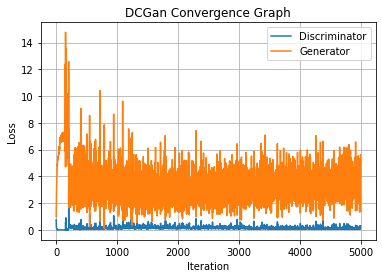

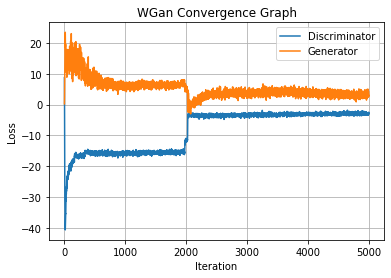

In [ ]:
for i,loss_set in enumerate(loss_df_set): 
  loss_df, G_Weights, D_Weights = loss_set
  f, ax = plt.subplots()
  loss_df.astype(float).plot(ax=ax)
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Loss')
  ax.grid()
  if i==0: ax.set_title('DCGan'+ ' Convergence Graph')
  else: ax.set_title('WGan'+ ' Convergence Graph')


**2. Load Gan's weights and generate images.** *Generates images of class 'T-shirt/top' and 'Trouser'.*


Fake image of a shirt, generated by WGan


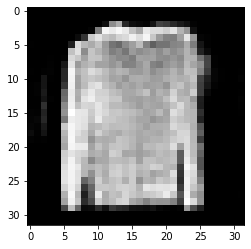

In [ ]:
# set a seed to contol which images are pulled
torch.random.manual_seed(0)

# load pre-trained weights
DC_G_Weights = torch.load(f'{path}/DCGan_Generator_Weights.pt')
W_G_Weights = torch.load(f'{path}/WGan_Generator_Weights.pt')

for i,G_Weights in enumerate([DC_G_Weights,W_G_Weights]):
  # create a generator with the weights
  generator = Generator().to(device)
  generator.load_state_dict(G_Weights)

  # create noise and generate fake images from it
  noise = torch.randn(batch_size, latent_size).to(device)
  noise = autograd.Variable(noise)
  fake = autograd.Variable(generator(noise).data)

  # save examles and plot two shirts...
  if i==0:   
    DC_shirt = fake[1].cpu().reshape((32,32))
    DC_pants = fake[6].cpu().reshape((32,32))
    DC_examples = [DC_shirt, DC_pants]

  else: 
    W_pants = fake[3].cpu().reshape((32,32))
    W_shirt = fake[4].cpu().reshape((32,32))
    W_examples = [W_shirt, W_pants]

    print('Fake image of a shirt, generated by WGan')
    plt.imshow(fake[4].cpu().reshape((32,32)), cmap='gray')


**3. Load real images and plot together.** *Real images, taken straight from the dataset, were chosen accourding to the classes of the fake ones.*

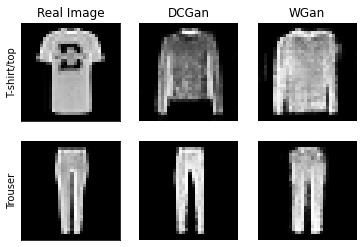

In [ ]:
class_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7:'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

fig, ax = plt.subplots(2, 3)
for i, classNum in enumerate([0, 1]):  #[0,1] is a lst of class ids
  # load image of this class
  image_indx = random.sample(np.argwhere(imported_testset.targets==classNum)[0].tolist(), 1)
  image= imported_testset.data[image_indx].numpy().squeeze()

  # setup plot
  ax[i,0].imshow(np.pad(image, 2), cmap='gray')
  ax[i,0].set_ylabel(class_dict[classNum])
  ax[i,0].set_xticks([]) 
  ax[i,0].set_yticks([]) 
  ax[i,0].tick_params(axis=u'both', which=u'both',length=0)

  if i==0:  ax[i,0].set_title('Real Image')
  for j, exmpl in enumerate([DC_examples, W_examples]):
      ax[i, j+1].imshow(exmpl[i], cmap='gray')
      ax[i, j+1].axis('off')
      ax[0, 1].set_title('DCGan')
      ax[0, 2].set_title('WGan')

      
fig.savefig(f'{path}/Comparsion of real and fake images.png')
